## Introduction

Humanity is currently tackling one of the biggest problem that they have ever faced in the form of Covid-19 pandemic. This has a trickle down effect on various aspects of human life. This includes the decrease or increase in number of crimes during lockdown. According to numerous reports (The Economist, 2020), there has been an increase in domestic violence as a result of lockdown. In this study, we will develop a big data product which analyses the pattern of violent crime during lockdown in Britain. The study ultimately aims to answer the question whether there is an overall increase in crime during the lockdown.

 
We make use of "Street Level Crime Data" published by the UK Home Office. This is huge data set containing million of entires. With the help of pySpark using RDD, SparkSQL, dataframes and pandas, and code written as python, we will analyse, predict and compare various data on violent crimes.




#### Importing Libraries:

In this step, we are importing all the libriries that are required for the study. This include numpy, pandas, warnings, matplotlib etc. We aslo create Spark Context connection as 'sc'.
Few of the major libraries include pandas, matplotlib for visualization, numpy for any statistical analysis. We are also importing SQLContext so that temp views/tables can be created and SQL queries can be used.


In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore") # to ignore warning messages
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date

import statsmodels.api as sm

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession\
.builder\
.appName("Python Spark app")\
.getOrCreate()

#Check we have a spark context: Should show the spark version and app name
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark app>

SparkContext is loaded into 'sc'

In [4]:
from pyspark.sql import SQLContext

In [5]:
import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize']=(20,10)

Size of the figures/plots generated is set to (20,10) for proper visualization

#### Loading the dataset:

The data provided to us is a 2GB zipped file uploaded in a cloud location. This is a "Street Level Crime Data" published by the UK Home Office which contains records of various street crimes across UK starting 2010. The data includes various types of crimes of which we are only concerned about Violent crimes. The zip file is downloaded and uploaded to our local blob storage in Azure and the data is read to spark using the public blob storage url. Spark can directly load a zipped file in csv format to a dataframe.

The data acquired have multiple types of data. It is important that we identify each data type and create a user defined schema <b> myschema </b> which has all the required individual data types. For example, month is of date data type, Longitude and Latitude is of float data type, Crime ID is of integer data type. Once the my schema is defined, the entire data can be loaded into a data frame using schema=myschema argument to have the correct data type.

In [6]:
myschema = StructType(
    [StructField("CrimeID", IntegerType(), True),
     StructField("Month", DateType(), True),
     StructField("ReportedBy", StringType(), True),
     StructField("FallsWithin", StringType(), True),
     StructField("Longitude", FloatType(), True),
     StructField("Latitude", FloatType(), True),
     StructField("Location", StringType(), True),
     StructField("LSOACode", StringType(), True),
     StructField("LSOAName", StringType(), True),
     StructField("CrimeType", StringType(), True),
     StructField("LastOutcomeCategory", StringType(), True)])  

We use %%time command to get the timing for each step. Since we are dealing with large dataset, this will give us a clear understanding on how long each step takes. Data is loaded into spark by reading the public blob stirage link. We use addFile function to load all the files in the blob storage to spark. spark.read.csv command can be used to read the values from csv file directly into a data frame. This is a very useful funtion as it eliminates the need for coverting rdd to data frame. While using the spark.read.csv command, we can pass the file which needs to be read from csv using SparkFiles.get(). We can also ask spark to read the header with header=true and define data types using user defined schema using schema=myschema command

In [7]:
%%time

url = "https://cleetustorage.blob.core.windows.net/cleetusct/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(url)

ogdata = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, schema= myschema)

CPU times: user 18.5 ms, sys: 11.2 ms, total: 29.6 ms
Wall time: 1min 3s


Checking if data is loaded correctly by checking snippets of the data

In [39]:
ogdata.take(5)

[Row(CrimeID=None, Month=datetime.date(2010, 12, 1), ReportedBy='Avon and Somerset Constabulary', FallsWithin='Avon and Somerset Constabulary', Longitude=-0.8055999875068665, Latitude=51.81914138793945, Location='On or near Norfolk Terrace', LSOACode='E01017662', LSOAName='Aylesbury Vale 015C', CrimeType='Other crime', LastOutcomeCategory=None),
 Row(CrimeID=None, Month=datetime.date(2010, 12, 1), ReportedBy='Avon and Somerset Constabulary', FallsWithin='Avon and Somerset Constabulary', Longitude=-2.494365930557251, Latitude=51.41816711425781, Location='On or near Keynsham Road', LSOACode='E01014399', LSOAName='Bath and North East Somerset 001A', CrimeType='Anti-social behaviour', LastOutcomeCategory=None),
 Row(CrimeID=None, Month=datetime.date(2010, 12, 1), ReportedBy='Avon and Somerset Constabulary', FallsWithin='Avon and Somerset Constabulary', Longitude=-2.5119268894195557, Latitude=51.4094352722168, Location='On or near Harlech Close', LSOACode='E01014399', LSOAName='Bath and Nor

Below command shows the entire data frame and its content

In [40]:
ogdata.show()

+-------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+-------------------+
|CrimeID|     Month|          ReportedBy|         FallsWithin|Longitude| Latitude|            Location| LSOACode|            LSOAName|           CrimeType|LastOutcomeCategory|
+-------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+-------------------+
|   null|2010-12-01|Avon and Somerset...|Avon and Somerset...|  -0.8056| 51.81914|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|               null|
|   null|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418167|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|               null|
|   null|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath an

printSchema() command shows the structure of the data frame.

In [41]:
ogdata.printSchema()

root
 |-- CrimeID: integer (nullable = true)
 |-- Month: date (nullable = true)
 |-- ReportedBy: string (nullable = true)
 |-- FallsWithin: string (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOACode: string (nullable = true)
 |-- LSOAName: string (nullable = true)
 |-- CrimeType: string (nullable = true)
 |-- LastOutcomeCategory: string (nullable = true)



In [42]:
print(ogdata.count())

65078250


By taking the count of the data frame, we can see the actual size of the data. The dataset contains more than 65 million entries.

### Sub Questions:

To answer if the overal violent crimes have gone up or not, we are anwsering various sub questions which will help us in making a final conclusion. There are 6 questions in total, we will try to answer them using various techniques.

#### Question 1 : What crime categories does the Police data use?

To answer this question, we must find out the distinct Crime categories which the police use. One of the simplest way to find this is using an Sql query with distinct clause. 
We create a temp view called sqldata and query this view for further results.

In [8]:
ogdata.createTempView("sqldata")

Selecting disctinct CrimeType

In [47]:
ogcategory = spark.sql("select distinct CrimeType from sqldata")

Showing the output :

In [48]:
ogcategory.show()

+--------------------+
|           CrimeType|
+--------------------+
|       Bicycle theft|
|        Public order|
|               Drugs|
|Public disorder a...|
|         Other crime|
|             Robbery|
|Criminal damage a...|
|Theft from the pe...|
|         Shoplifting|
|            Burglary|
|       Violent crime|
|         Other theft|
|Possession of wea...|
|Violence and sexu...|
|       Vehicle crime|
|Anti-social behav...|
+--------------------+



We can use Pandas to better visualise the results

In [49]:
ogcategory.toPandas()

,CrimeType
0,Bicycle theft
1,Public order
2,Drugs
3,Public disorder and weapons
4,Other crime
5,Robbery
6,Criminal damage and arson
7,Theft from the person
8,Shoplifting
9,Burglary


#### Answer :
From the output, it is clear that the Police has used almost 16 sets of crime types while categorising the crimes. These categories are developed over a course of 11 years. Below are the categories used for street crime data: <br>
Bicycle theft <br>
Public order <br>
Drugs <br>
Public disorder and weapons <br>
Other crime <br>
Robbery <br>
Criminal damage and arson <br>
Theft from the person <br>
Shoplifting <br>
Burglary <br>
Violent crime <br>
Other theft <br>
Possession of weapons <br>
Violence and sexual offences <br>
Vehicle crime <br>
Anti-social behaviour <br>

#### Question 2 : Have the same categories been used consistently?

This question can be answered easily using a combination of group by and disctinct function. It is easier to check if the same categories are used consistently if we group it Year. Since or month column have year, month and date, we use the extract funtion in SQL to extract year from a date data type variable which in our case is month. Once the year is extracted, we group it by CrimeType and Year and select only the disticnt CrimeType.

In [85]:
%%time

ogmonthcat = spark.sql("select distinct CrimeType, EXTRACT(YEAR FROM Month) as Year from sqldata group by CrimeType, Year order by Year")

CPU times: user 0 ns, sys: 2.5 ms, total: 2.5 ms
Wall time: 24.7 ms


In [90]:
%%time
ogmonthcat.show(200)

+--------------------+----+
|           CrimeType|Year|
+--------------------+----+
|             Robbery|2010|
|         Other crime|2010|
|       Vehicle crime|2010|
|Anti-social behav...|2010|
|       Violent crime|2010|
|            Burglary|2010|
|Public disorder a...|2011|
|       Vehicle crime|2011|
|            Burglary|2011|
|Anti-social behav...|2011|
|       Violent crime|2011|
|Criminal damage a...|2011|
|               Drugs|2011|
|         Other theft|2011|
|         Shoplifting|2011|
|             Robbery|2011|
|         Other crime|2011|
|Anti-social behav...|2012|
|             Robbery|2012|
|Criminal damage a...|2012|
|       Violent crime|2012|
|         Other theft|2012|
|               Drugs|2012|
|       Vehicle crime|2012|
|Public disorder a...|2012|
|            Burglary|2012|
|         Other crime|2012|
|         Shoplifting|2012|
|            Burglary|2013|
|       Vehicle crime|2013|
|Anti-social behav...|2013|
|             Robbery|2013|
|Criminal damage a..

display.max_rows increases the number of rows displayed while showing toPandas() output.

In [93]:
%%time
pd.set_option('display.max_rows', 500)
ogmonthcat.toPandas()

CPU times: user 304 ms, sys: 108 ms, total: 413 ms
Wall time: 24min 38s


,CrimeType,Year
0,Burglary,2010
1,Other crime,2010
2,Vehicle crime,2010
3,Violent crime,2010
4,Robbery,2010
5,Anti-social behaviour,2010
6,Anti-social behaviour,2011
7,Other theft,2011
8,Drugs,2011
9,Shoplifting,2011


#### Answer :

From the output, it is clear that Police have changed the categories over the years. For example, in the year 2013 we can see that the category Violent crime changed to violent and sexual crime. 

However, starting 2014, same 14 categories have been constantly used. These categories are :<br> 

Drugs<br>
Bicycle theft<br>
Other theft<br>
Criminal damage and arson<br>
Public order<br>
Robbery<br>
Anti-social behaviour<br>
Possession of weapons<br>
Shoplifting<br>
Other crime<br>
Vehicle crime<br>
Theft from the person<br>
Burglary<br>
Violence and sexual offences<br>


#### Question 3 : Are levels of violent crime constant, increasing, or decreasing?

Before answering this question, we must clean up our data a little. First off, lets define Violent crime as violent and sexual crimes. Question 2 clearly indicates that the sexual and violent crime category was first used in the year 2013. Hence, if we are considering Violent and sexual crimes, we can filter the data staring from 2014. This will also make our time series forecasting more consistant as we are selecting rolling window for mean and standard deviation as 12. Also, we are filtering the data till the year 2020. Data from the year 2021 is not absolutely nessesary for analysing the rest of the questions and hence can be eliminated. This also ensures that our data can be made stationary while using data series prediction. All this inturn reduces the size of the data and hence will be easy to manipulate. We are selecting count of the violent and sexual crimes as CrimeNumbers. The final dataframe only consists of 2 columns, one is the month and other is the count of violent crime for the corresponding month. This will help us in correctly determining whether or not violent crimes are increasing using Time Series Analysis.

#### Time Series Analysis : 

When researching a phenomena, we frequently come across a data collection with observations in chronological sequence. A time series is a time-ordered succession of observations (Wei, 2006). A two-dimensional graphic of time series data is called a time-series plot (time plot) where horizontal axis have time and vertical axis have our response variable. In this study, we use time plot to check the trend of violent crime. 

As explained above, we filter the entire dataset with crime type = Violence and sexual offences. Then we can use group by function to get the count of violent crime corresponding to each month. spark.sql funtion is used to fileter the data save it as new data frame.

In [92]:
filtereddata = spark.sql("select Month, count(CrimeType) as CrimeNumbers FROM sqldata where CrimeType='Violence and sexual offences' and Month >= '2014-01-01' and Month <= '2020-12-31' group by Month order by Month")

toPandas() to print the data.

In [93]:
%%time
filpanda = filtereddata.toPandas()
filpanda

CPU times: user 311 ms, sys: 107 ms, total: 418 ms
Wall time: 25min 28s


,Month,CrimeNumbers
0,2014-01-01,59291
1,2014-02-01,56798
2,2014-03-01,65372
3,2014-04-01,62825
4,2014-05-01,69063
5,2014-06-01,74066
6,2014-07-01,78459
7,2014-08-01,71341
8,2014-09-01,74723
9,2014-10-01,76405


Pandas ususally have index created by default but for visualizing data using time series, we need index based on datetime64 data type. Hence we create a new pandas data frame with index set as month using set_index() function.

In [94]:
%%time
filpanda.Month = filpanda.Month.astype('datetime64[ns]')
filpanda2 = filpanda.set_index(pd.to_datetime(filpanda.Month))

CPU times: user 0 ns, sys: 5.39 ms, total: 5.39 ms
Wall time: 4.48 ms


Checking the index of new panda using .index() function

In [95]:
%%time
filpanda2.index

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 11.4 µs


DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
      

.plot() in pandas can be used to create graph with month on x axis and CrimeNumbers on y axis. To visualize the graph on the screen, we may use Pyplot, a submodule of the Matplotlib package.
Various other attributes like marker, linestyle, linewidth for .plot() function can be used to better visualize the graph.

In [96]:
%%time
plt.figsize=(20, 10)

filpanda2.plot(y='CrimeNumbers', x='Month',marker='.', linestyle='-', linewidth=1,\
         subplots=False,
              label='Monthly Crime Numbers',
              title='Crime Numbers Vs Month')
plt.ylabel('Crime Numbers')
plt.xlabel('Year')

CPU times: user 72.2 ms, sys: 11.1 ms, total: 83.3 ms
Wall time: 80.8 ms


Text(0.5, 0, 'Year')

.show() launches one or more interactive windows that display our figure by searching for all currently active figure objects.

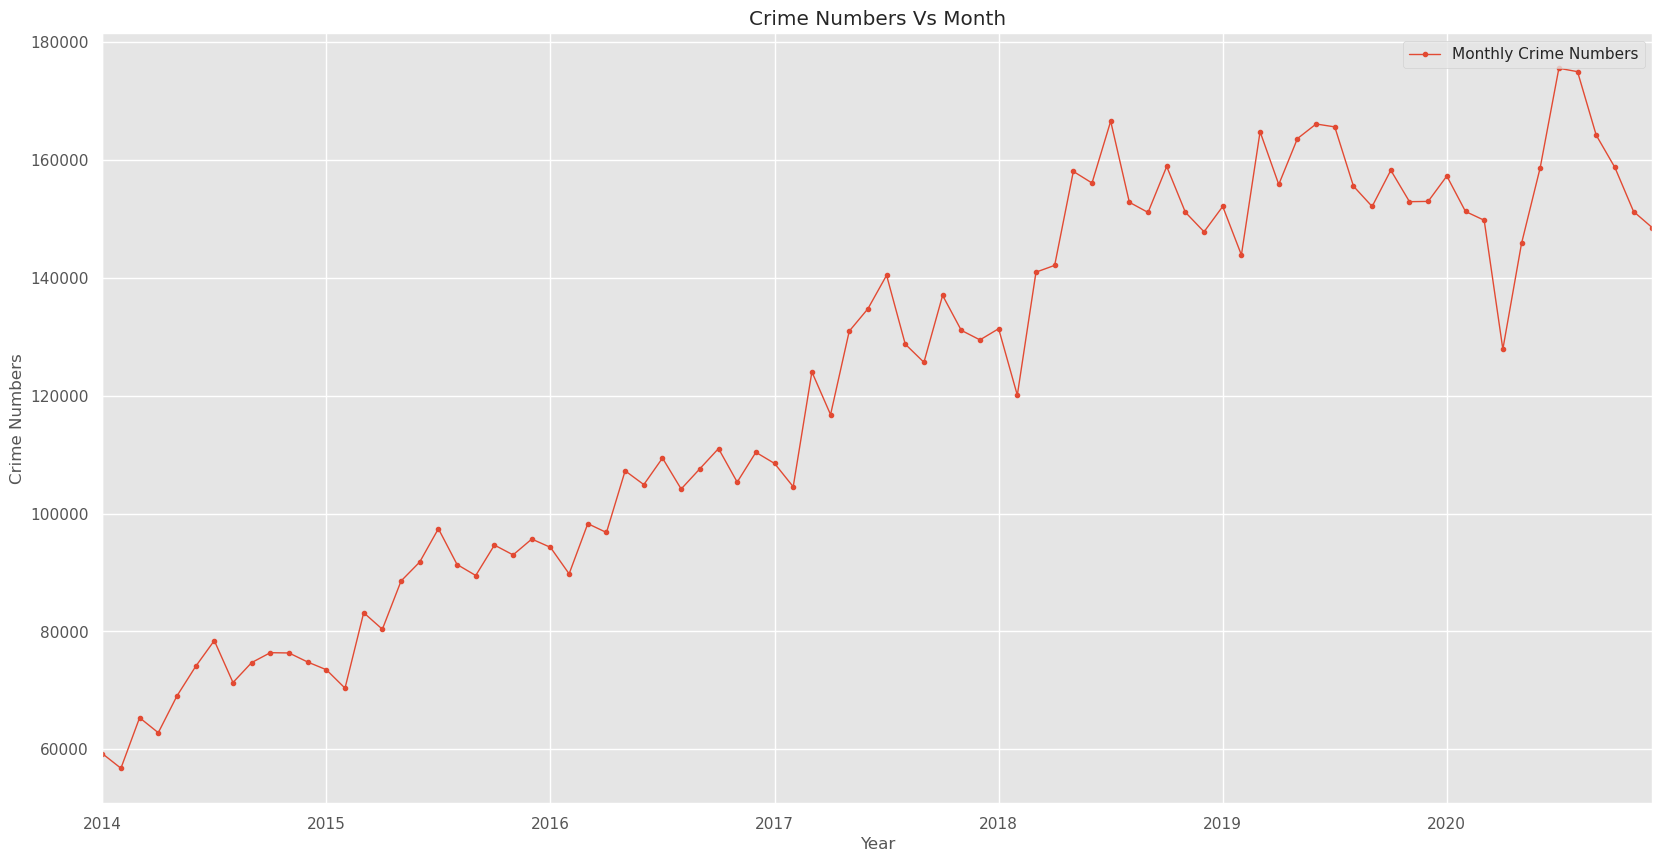

CPU times: user 346 ms, sys: 38.1 ms, total: 384 ms
Wall time: 365 ms


In [97]:
%%time
plt.show()

Decomposing a time series entails spliting it as a collection of level, trend, seasonality, and noise components. <br>
The average value in the series is called the level.<br>
The increasing or decreasing value in the series is referred to as the trend.<br>
Seasonality is the series' recurring short-term cycle.<br>
The random variations in the series is referred to as noise.<br>

In an addictive model, y(t) = Level + Trend + Seasonality + Noise <br>

We use sm.tsa.seasonal_decompose() function to decompose our time series data into trend, seasonal variations and noise. Output graphs are as shown below.

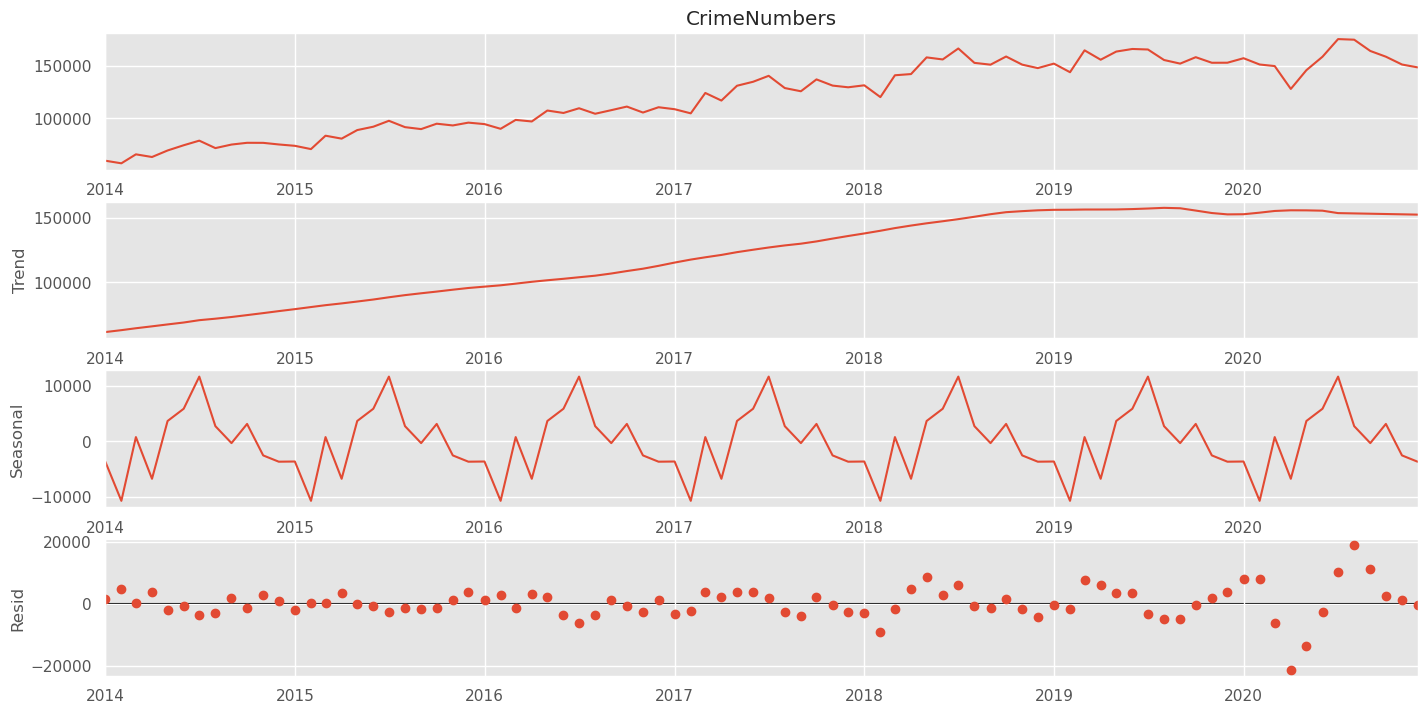

In [98]:
decomposition = sm.tsa.seasonal_decompose(filpanda2['CrimeNumbers'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

#### Answer:
From the graphs plotted, it is very clear that <b>violent crimes have been on the rise</b> from 2013. The trend clearly shows an increase in the slope. However the numbers have been almost constant after 2019, steep slope in trend has been flattened. We can also see some seasonal variations in violent crime numbers where the crime numbers go up drastically during summer and subsequently reduce during winter.

#### Question 4 : Using data prior to the first lockdown predict violent crime levels for April 2020

Before using time series forecasting, we must ensure that the data is stationary. When the mean and variance of a time series remain constant across time, it is called a stationary time series. A stationary time series has qualities that are independent of the time at which it is viewed (Kwiatkowski et al., 1992).

For this study, we are choosing the rolling window as 12. First we define a function test_stationarity which calculates rolling mean and rolling standard deviation for an input time series and plots the original time series, rolling mean, rolling standard deviation in a single plot. We use rolling().mean() and rolling().std() to find rolling mean and standard deviation. This gives us a visual representation to check for stationarity.

In [99]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

options.display.float_format = '{:.8f}'.format is used to round off float to 8 decimal points. We then call the test_stationarity function by passing CrimeNumbers series as input.

<Figure size 2000x1000 with 0 Axes>

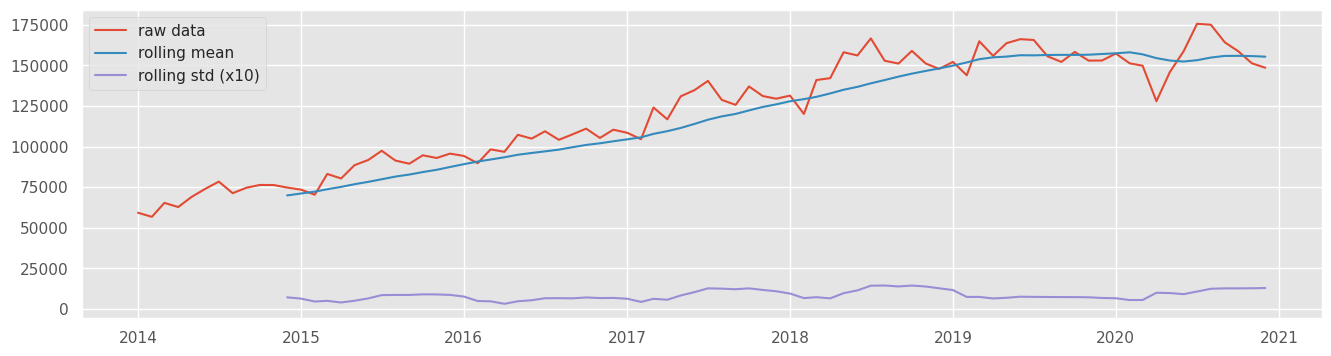

In [120]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(filpanda2['CrimeNumbers'],'raw data')

From the plots, we can see that the series is not stationary in nature.

Visual analysis is not conclusive of data stationarity hence we must employ statistical methods as well. The ADF Test (Augmented Dickey Fuller Test) is a typical statistical test for determining whether or not a time series is stationary. We will create a function ADF_test which checks if the data is stationary or not. We use adfuller function from statsmodels.tsa.stattools which provides us with outputs such as test statistic, P-value, Critical values at 1,5 and 10 %.

In [121]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [122]:
ADF_test(filpanda2['CrimeNumbers'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.799
P-value = 0.381
Critical values :
	1%: -3.526004646825607 - The data is not stationary with 99% confidence
	5%: -2.9032002348069774 - The data is not stationary with 95% confidence
	10%: -2.5889948363419957 - The data is not stationary with 90% confidence


The output from ADF Test clearly indicates that the data is not stationary. We must use various methods such as detrending and differencing to achieve stationary data. 

Detrending : Detrending is the process of eliminating the impacts of trend from a data. We detrend the data by subtracting the data with the quotient of its rolling mean and rolling standard deviation. The new detrended series is then tested for stationarity using test_stationarity and ADF_test functions.

<Figure size 2000x1000 with 0 Axes>

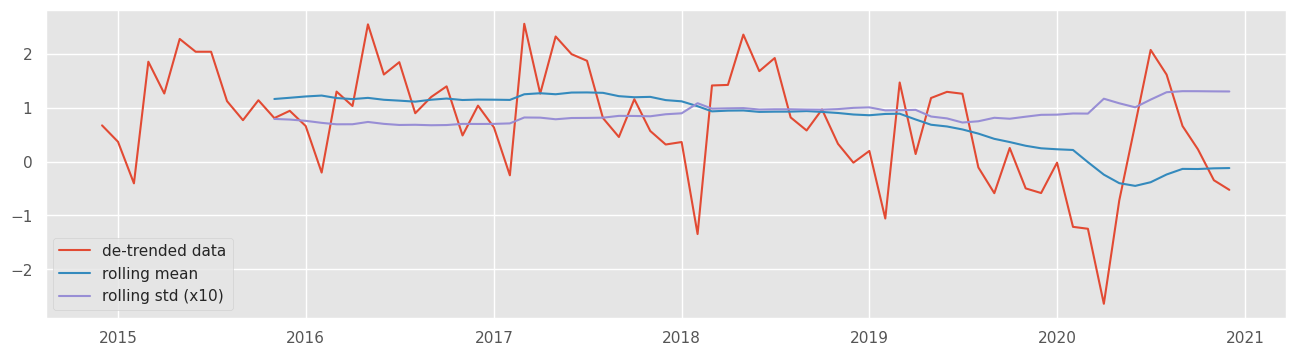

 > Is the de-trended data stationary ?
Test statistic = -0.294
P-value = 0.926
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence


In [123]:
# Detrending
y = filpanda2['CrimeNumbers']
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

From the output, it is clear that the detrended data is also not stationary. Hence, we will try to make it stationary using differencing technique. 


Differencing : Differencing is done by  subtracting the past observation from the present observation. .shift() function changes the index by the number of periods specified. Here we use the period as 12 and subract the original series shifted by a period of 12. This is then again passed to test_stationarity and ADF_test functions to test for stationarity.

<Figure size 2000x1000 with 0 Axes>

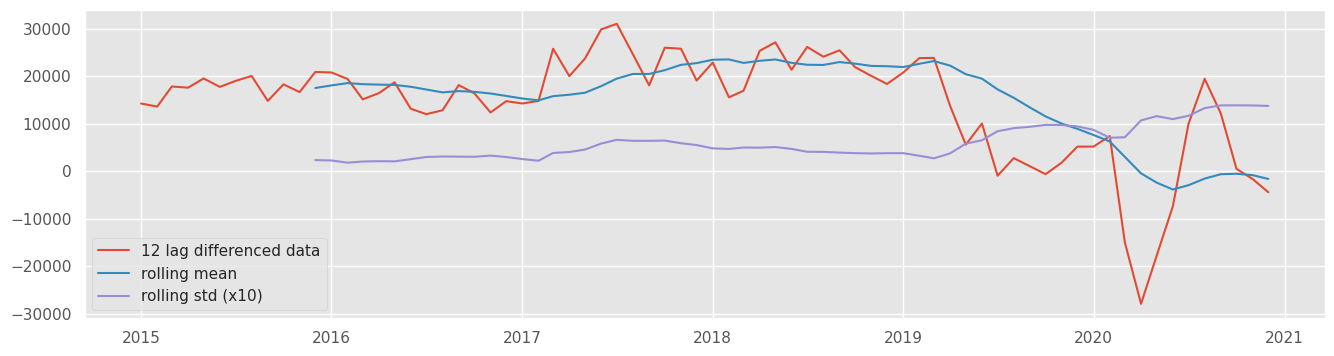

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.133
P-value = 0.702
Critical values :
	1%: -3.5319549603840894 - The data is not stationary with 99% confidence
	5%: -2.905755128523123 - The data is not stationary with 95% confidence
	10%: -2.5903569458676765 - The data is not stationary with 90% confidence


In [124]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

From the output, we can see that the data is not yet stationary. Hence we employ both detrending and differencing together. The initial detrended data is differenced by a period of 12 and is passed to test_stationarity and ADF_test functions.

<Figure size 2000x1000 with 0 Axes>

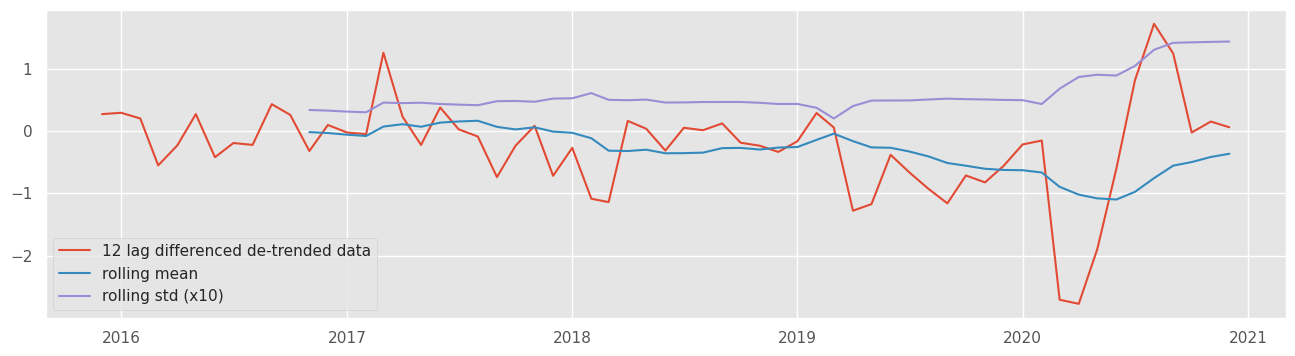

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.437
P-value = 0.000
Critical values :
	1%: -3.5463945337644063 - The data is  stationary with 99% confidence
	5%: -2.911939409384601 - The data is  stationary with 95% confidence
	10%: -2.5936515282964665 - The data is  stationary with 90% confidence


In [125]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')

ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

Finally, the data is staionary. Now we can use ARIMA method to forecast or predict future values, in our case predict the crime numbers of April 2020 using prior values.


We also export detrended and differenced data ro a csv for any future use.

In [126]:
y_12lag_detrend.to_csv("Detrend_Crime_Data.csv")

In this study, We use SARIMA model to predict the future values based on given set of past taining values.

ARIMA stands for Autoregressive Integrated Moving Average. It incorporates AR and MA models, as well as a sequence differencing pre-processing step Integration I, to make the sequence stationary.

Seasonal ARIMA (SARIMA) models:
As the name suggests, this model is employed when the time series demonstartes seasonality. This model is similar to ARIMA models, with the exception that we need to add a few parameters to account for the seasons.


We write SARIMA as ARIMA(p,d,q)(P, D, Q)m</br>
p — autoregressive number</br>
d — differencing degree</br>
q — moving average terms number</br>
m — the number of periods in each season</br>
(P, D, Q )— represents the (p,d,q) for the seasonal part of the time series</br>

The detrended differenced data is used for predicting the future numbers. The null values are removed from the detrended differenced data 

In [127]:
y2 = y_12lag_detrend.dropna()

In [128]:
y2.head()

Month
2015-12-01    0.27015536
2016-01-01    0.29159554
2016-02-01    0.19979650
2016-03-01   -0.55309397
2016-04-01   -0.23177476
Name: CrimeNumbers, dtype: float64

Data to train is the data till April, data to test is the data from April.

In [139]:
y_to_train = y2[:'2020-03-31'] # dataset to train
y_to_test = y2['2020-04-01': ] # dataset to test

We need to get a list (p, d, q) parameters and seasonal (P,D,Q) parameters. We exhaustively iterate all possible values of these parameters using itertools.produc() function. These values are stored in pdq and seasonal_pdq.

In [130]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


To find the ideal values for pdq, we use Akaike's Information Criterion (AIC) values. Lower the AIC value, the better the results. We use sm.tsa.statespace.SARIMAX() function to carry out a grid search find the AIC values for each possible pqd and seasonal pdq. 

In [113]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:104.8207942991578
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:105.72297987670996
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:108.9683822219367
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1435.145548770428
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:104.8770559275978
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:102.43853187093902
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:94.14592438307722
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:94.12803134668641
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:94.7913495560144
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:94.55594181555176
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:104.39886065519204
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1539.198681375613
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:93.81700797652746
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:91.13409791836301
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:91.05448543396494
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:89.62895831552419
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:99.38436380443454
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:90.61900269400851
ARIMA(0,

From the output, we can see that the lowest value for AIC is for the below parameters. 

ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:78.87211524446748
    
Hence, these values can be used as order and seasonal order along with data to train to sm.tsa.statespace.SARIMAX() function to get a predictive model.

In [131]:
order = (0, 1, 1) #Using Values from the previous step
seasonal_order = (1, 0, 0, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

Results are then plotted Residue, Histogram, Q-Q, and Correlogram

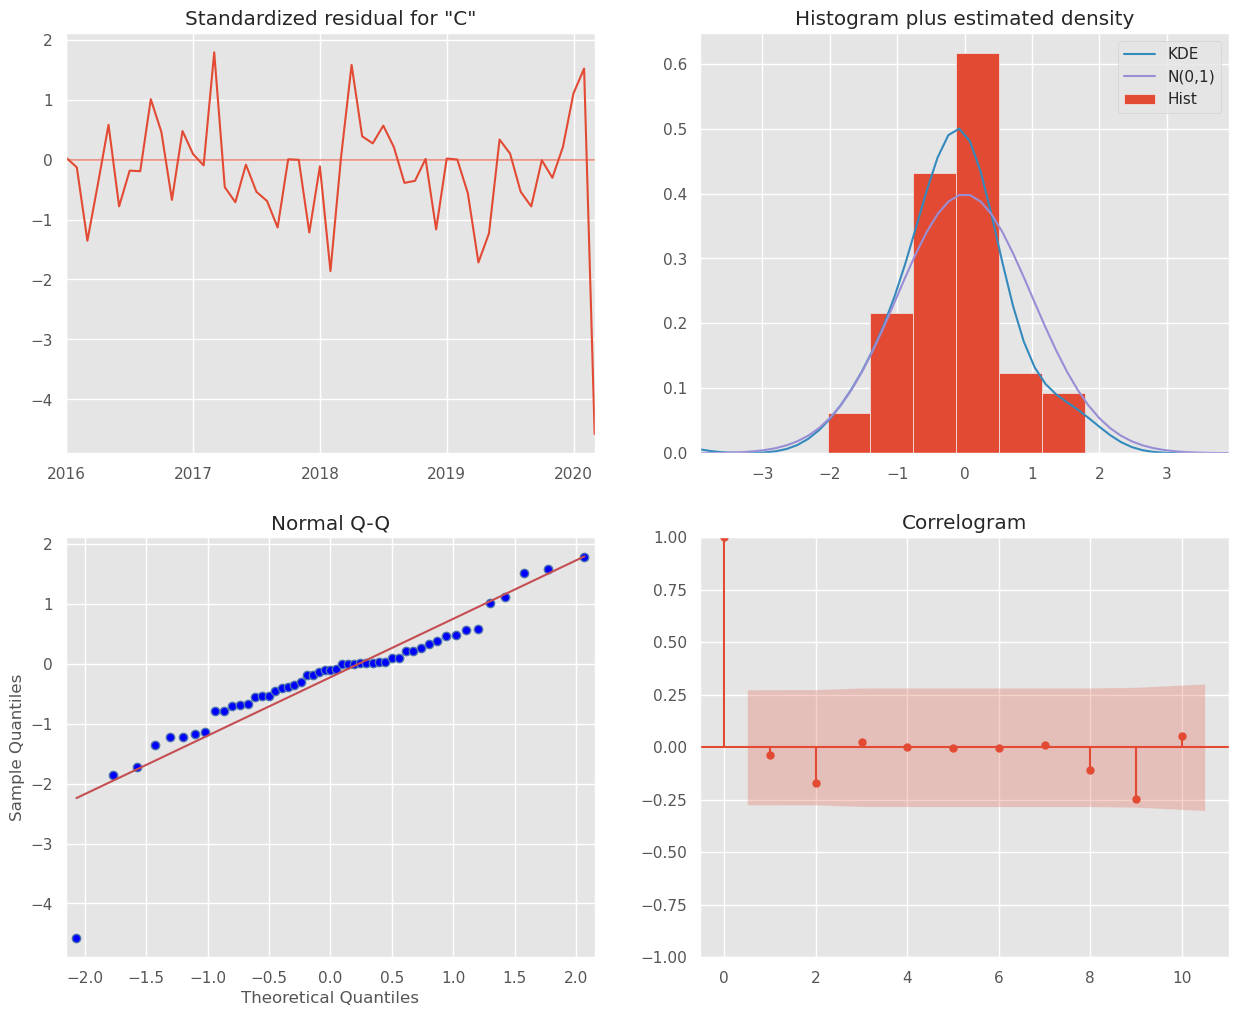

In [133]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

From the output graphs, we can see that the residues are stationary with same mean and variance and withouut trend, Q-Q plot rougjly straight, Correlogram points are within boundary, histogram is normal. 

To predict the output of future results, we use get_forecast() function with step=12 which will predict the values for next 12 months.
conf_int() is used to get the confidence interval with 95% certainity.

In [141]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

Output is then visualized using plot function. Original data is plotted along with predicted mean of pred_uc which is the predicted results and also the confidence interval.

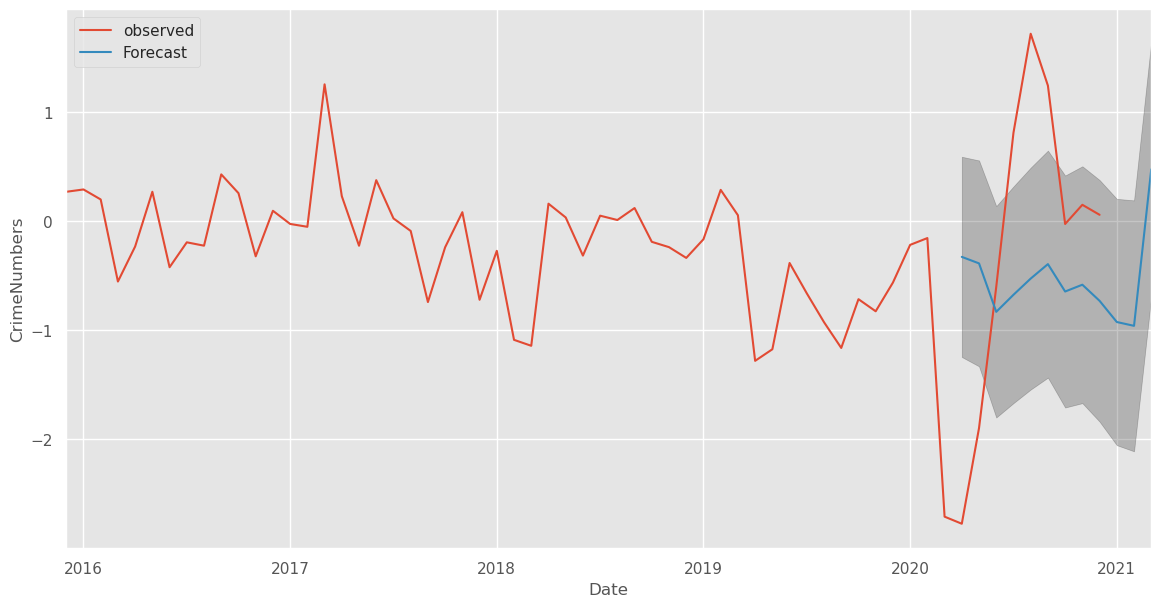

In [144]:
ax = y2.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y2.name)

plt.legend()
plt.show()

We can then produce a forecast table having predicted mean, upper and lower bounds. One table pm is created with predicted mean and another table pci is created with predicted upper and lower boundaries. These 2 tables are then joined to get the final table. We can use the final table to compare results with data to test.

In [136]:
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')

In [137]:
final_table.head(12)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-04-01,-0.32691768,-1.24536756,0.59153221
1,2020-05-01,-0.38658069,-1.33086528,0.55770390
2,2020-06-01,-0.83115190,-1.80058295,0.13827916
3,2020-07-01,-0.67459346,-1.66853498,0.31934806
4,2020-08-01,-0.52602409,-1.54388603,0.49183785
5,2020-09-01,-0.39334737,-1.43458034,0.64788561
6,2020-10-01,-0.64470837,-1.70879920,0.41938246
7,2020-11-01,-0.58228996,-1.66875785,0.50417793
8,2020-12-01,-0.73014033,-1.83853361,0.37825294
9,2021-01-01,-0.92449234,-2.05438563,0.20540094


#### Answer :
    
From the output in final table, it can be seen that the predicted mean for April 2020 is around -0.32691768 with upper and lower boundaries at 0.59153221 and -1.24536756 respectively. The actual mean for the month of March is -2.71 as seen from detrend differenced csv. This means, according to our predictive midel, that the total number of violent crime should see a steep increase (diff detrended mean from -2.71 to -0.326) in the month April.

#### Question 5 : Compare predicted crime levels with actuals, and so determine whether significant changes to violent crime occurred

Below are the actual values to test and values predicted respectively.

In [138]:
y_to_test.head(9)

Month
2020-04-01   -2.77519573
2020-05-01   -1.89706826
2020-06-01   -0.60172282
2020-07-01    0.81195856
2020-08-01    1.72003232
2020-09-01    1.24410536
2020-10-01   -0.02520384
2020-11-01    0.15084966
2020-12-01    0.05904624
Name: CrimeNumbers, dtype: float64

In [145]:
final_table.head(12)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-04-01,-0.32691768,-1.24536756,0.59153221
1,2020-05-01,-0.38658069,-1.33086528,0.55770390
2,2020-06-01,-0.83115190,-1.80058295,0.13827916
3,2020-07-01,-0.67459346,-1.66853498,0.31934806
4,2020-08-01,-0.52602409,-1.54388603,0.49183785
5,2020-09-01,-0.39334737,-1.43458034,0.64788561
6,2020-10-01,-0.64470837,-1.70879920,0.41938246
7,2020-11-01,-0.58228996,-1.66875785,0.50417793
8,2020-12-01,-0.73014033,-1.83853361,0.37825294
9,2021-01-01,-0.92449234,-2.05438563,0.20540094


#### Answer :
    
From the tables, it is observed that there is a significant error in the value predicted for the month of April 2020. According to our predictive model, the predicted mean for April 2020 is -0.32691768 however the actual value is -2.77519573. This value  even lie outside the 95% confidence interval. If we check the graph plotted earlier with actual and predicted values, it is seen that the actual value for April has decreased when comapred to March 2020. 

We can infer that the there is a significance deviation from the normal patern in crime numbers for the month of April 2020 where there has been an unexpected drop in number of crimes.

#### Question 6 : The Leicester region was put in a local lockdown in July 2020. Verify your findings (if any) with respect to that region only.

To answer this question, we have to first filter the entire data set accordingly. We will create a new data frame with LSOAName like 'Leicester' and critype as violent and sexual offense. We can further sample this data from the begining of 2019 as we dont require previous set of data to analyse the pattern after lockdown in 2020. Dataset starting from 2019 is huge enought to get a clear picture of the monthwise trend. 

In [215]:
ogdata.createTempView("sqlq61")

In [216]:
q6 = spark.sql("SELECT CrimeType, Month, LSOAName FROM sqlq61 where LSOAName like ('%Leicester%') and CrimeType in ('Violent crime','Violence and sexual offences') and Month >= '2019-01-01' order by Month, LSOAName")

In [217]:
q6.createTempView("sqlq61v2")

We also group the count of violent crimes by month.

In [218]:
q6v2 = spark.sql("SELECT count(CrimeType) as CrimeNumbers, Month FROM sqlq61v2 group by Month order by Month")

In [220]:
%matplotlib inline

Output of the filtered data is coverted to pandas.

In [221]:
%%time
q6v2panda = q6v2.toPandas()

CPU times: user 312 ms, sys: 93.9 ms, total: 406 ms
Wall time: 23min 58s


In [222]:
%%time
q6v2panda

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


,CrimeNumbers,Month
0,1484,2019-01-01
1,1333,2019-02-01
2,1455,2019-03-01
3,1430,2019-04-01
4,1390,2019-05-01
5,1358,2019-06-01
6,1505,2019-07-01
7,1537,2019-08-01
8,1489,2019-09-01
9,1409,2019-10-01


Once the pandas is created from the filtered data, we use simple plot.bar() function with crime numbers in y axis and month in x axis to plot the trend in crime numbers for Leicester region.

CPU times: user 113 ms, sys: 1.43 ms, total: 114 ms
Wall time: 104 ms


<AxesSubplot:xlabel='Month'>

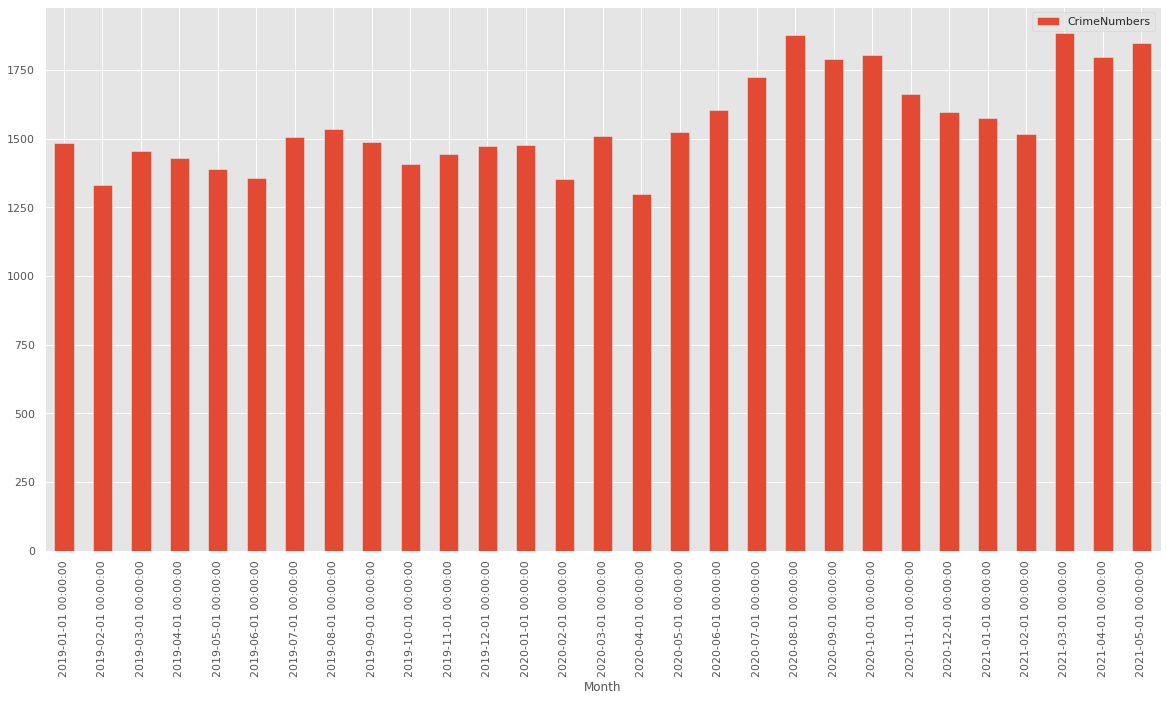

In [226]:
%%time
q6v2panda.plot.bar(x='Month', y='CrimeNumbers')

Similarly for better visulization, we can use .plot() in pandas to create a time plot for number of violent crimes vs month similar to that of the graph created for question 3.

In [227]:
q6v2panda.Month = q6v2panda.Month.astype('datetime64[ns]')
q6v2panda2 = q6v2panda.set_index(pd.to_datetime(q6v2panda.Month))

In [228]:
q6v2panda2.index

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

Text(0, 0.5, 'Crime Numbers')

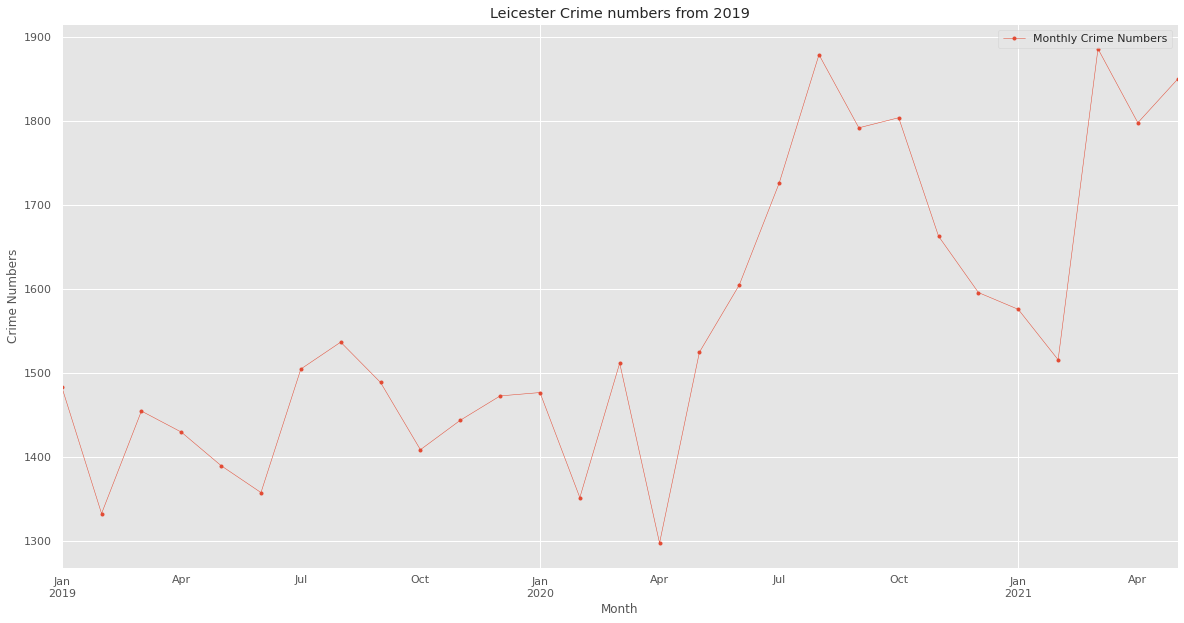

In [229]:
plt.figsize=(20, 6)

q6v2panda2.plot(y='CrimeNumbers', x='Month',marker='.', linestyle='-', linewidth=0.5,\
         subplots=False,
              label='Monthly Crime Numbers',
              title='Leicester Crime numbers from 2019')
plt.ylabel('Crime Numbers')

#### Answer :

A local lockdown was imposed in Leicester region in July 2020. By analysing the data in a graphical approcah, we can see that there is a <b>significant increase in number of violent crimes</b> for July and August 2020. This could be attributed to the local locakdown imposed on the region.

## Conclusion:


Various questions were posed for us to better analyze the given dataset. Police had gathered data for the street crimes reported starting 2010 and has almost 65M entries in it. The categories of the the type of crime has been suject to change over the year but it has been constant since 2014. The category violent crime was concerted to violent and sexual offence in 2013. 

By using the data from 2014, it is very clearly evident that there is an overall increase in violent crime every year. Please refer the figure below.

However, it was noticed that the <b>number of crime started remaining static</b> around 2020 with the onset of COVID-19 and subsequent lockdown. If we check the 'Trend' component of our time series analysis, this fact is very evident. We can also check the counts using pandas and we can see that the counts almost remian constant during lockdwon with numbers fluctuating between 15K to 17K violent crimes. We can also see the seasonal variations in crime where violent crime increases during summer and decreases during winter. There are some exceptions to this such as city Leicester where the crime numbers have actualy gine up during the month of July.

<b>With the data we have analysed, it is safe to conclude that the number of violent crimes havent increased as expected during lockdown, infact it has gone against the general trend of increase in yearly numbers and have remained almost constant.</b>




## References

Kwiatkowski, D., Phillips, P.C., Schmidt, P. and Shin, Y., 1992. Testing the null hypothesis of stationarity against the alternative of a unit root: How sure are we that economic time series have a unit root?. Journal of econometrics, 54(1-3), pp.159-178.


The Economist, 2020 "Domestic Violence Has Increased during Coronavirus Lockdowns; Daily Chart." The Economist (London) (2020): The Economist (London), 2020-04-22. Web.


Wei, W.W., 2006. Time series analysis. In The Oxford Handbook of Quantitative Methods in Psychology: Vol. 2.


